# Neural event detection: 
### A simple example

Author: Ali Zaidi

Date 20.08.2019

In [1]:
from __future__ import print_function, absolute_import

In [2]:
from scipy.signal import stft, istft, find_peaks
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [65]:
# Load the data
fname = "./data/Time_Series_N2_long.mat"
data = sio.loadmat(fname)
Vp=data['Vp']

In [66]:
# Separate the data into train and test set

split =3*Vp.shape[1]//4

Vp_train = Vp[:,:split]
Vp_test = Vp[:,split:]

In [67]:
print(Vp_train.shape, Vp_test.shape)

(1, 9000000) (1, 3000000)


In [68]:
# Obtain STFT of training data

nperseg=1024
noverlap=16

f, t, data_stft = stft(Vp_train, fs=1000, nperseg=nperseg, noverlap=noverlap, axis=1)
data_stft = np.abs(np.squeeze(data_stft)) # Required for normalization
data_stft = data_stft[:100,:]
f = f[:100]

In [69]:
# Normalize STFT

dsm = np.mean(data_stft, axis=1)
dsm_r = np.repeat(dsm[:, np.newaxis], data_stft.shape[1], axis=1)

dsd = np.std(data_stft, axis=1)
dsd_r = np.repeat(dsd[:, np.newaxis], data_stft.shape[1], axis=1)

data_stft_norm = (data_stft - dsm_r) / dsd_r

In [ ]:
plt.plot(Vp_train[:,:100000])

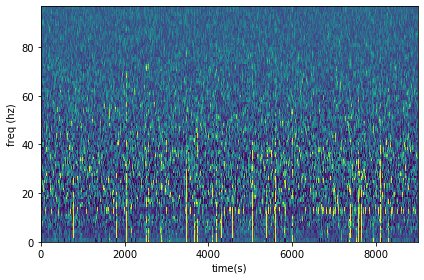

In [70]:
# Visualize
plt.figure()
plt.pcolormesh(t, f, data_stft_norm)
plt.clim([-1, 2])
plt.xlabel('time(s)')
plt.ylabel('freq (hz)')
plt.tight_layout()

### Manifold approximation based dimensionality reduction

In [71]:
# Embed the STFT frames in a lower dimensions. This helps visualization of clusters
from umap import UMAP
manifold = UMAP()
embedding = manifold.fit_transform(data_stft_norm.T)

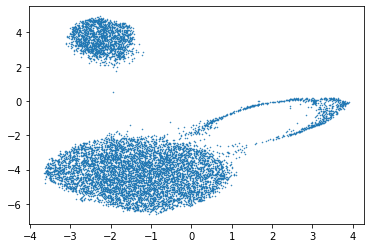

In [72]:
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], marker='.', alpha=1, s=1)

In [13]:
# Fit a model
from sklearn.mixture import BayesianGaussianMixture
dpgmm = BayesianGaussianMixture(n_components=3).fit(embedding)
labels = dpgmm.predict(embedding)

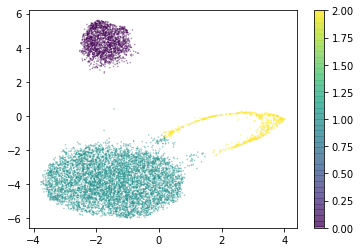

In [14]:
# Visualize clusters
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], marker='.', alpha=0.5, c=labels, s=1)
plt.colorbar()

In [15]:
# Obtain the label counts (Assumption: background activity is much more common than our events of interest)
values, counts = np.unique(labels, return_counts=True)
print(dict(zip(values, counts)))

{0: 1772, 1: 6457, 2: 701}


In [73]:
from sklearn.cluster import DBSCAN
clustering=DBSCAN().fit(embedding)
l=clustering.labels_
# Obtain the label counts (Assumption: background activity is much more common than our events of interest)
values, counts = np.unique(l, return_counts=True)
print(dict(zip(values, counts)))

{-1: 1, 0: 7168, 1: 1761}


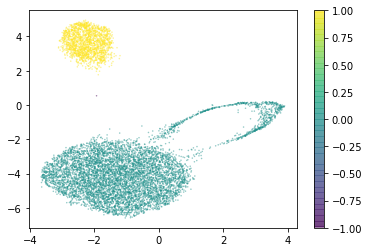

In [74]:
# Visualize clusters
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], marker='.', alpha=0.5, c=l, s=1)
plt.colorbar()

## Applying transformations to new data

In [16]:
nperseg=1024
noverlap=16

f, t, data_stft = stft(Vp_test, fs=1000, nperseg=nperseg, noverlap=noverlap, axis=1)
data_stft = np.squeeze(data_stft)
data_stft_abs = np.abs(data_stft) # Required for normalization

data_stft_abs = data_stft_abs[:100,:]
f = f[:100]

In [57]:
dsm_r = np.repeat(dsm[:, np.newaxis], data_stft_abs.shape[1], axis=1)
dsd_r = np.repeat(dsd[:, np.newaxis], data_stft_abs.shape[1], axis=1)

data_stft_norm = (data_stft_abs - dsm_r) / dsd_r

data_stft_norm_filt = data_stft_norm
data_stft_norm_filt[data_stft_norm_filt<1.96]=0

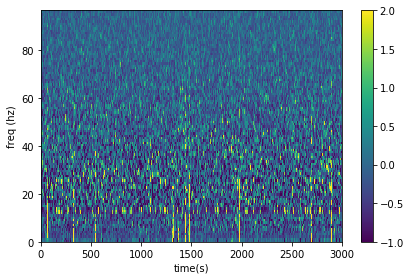

In [52]:
plt.figure()
plt.pcolormesh(t, f, data_stft_norm)
plt.clim([-1, 2])
plt.xlabel('time(s)')
plt.ylabel('freq (hz)')
plt.colorbar()
plt.tight_layout()

### Manifold approximation based dimensionality reduction

In [19]:
embedding2 = manifold.transform(data_stft_norm.T)

In [20]:
labels2 = dpgmm.predict(embedding2)

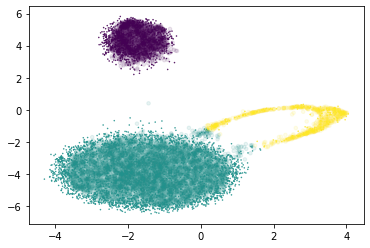

In [21]:
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1], marker='.', alpha=0.1, s=50, c=labels)
plt.scatter(embedding2[:,0], embedding2[:,1], marker='.', alpha=1, s=1, c=labels2)

As you can see, the test data overlaps almost perfectly with the training dataset

## Retrieving the filtered timeseries for each event

In [22]:
# Get the counts for each clustered datapoint
values, counts = np.unique(labels2, return_counts=True)

In [23]:
# Assume that background activity is the most common kind of activity
# Remove the label with the highest count
values = values[counts!=max(counts)]
counts = counts[counts!=max(counts)]

In [24]:
# Assign eventIDs to labels
event1_label = values[0]
event2_label = values[1]

### For event type1

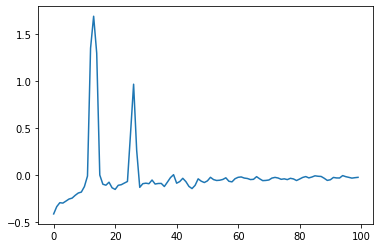

In [38]:
# Obtain the most prominent frequencies
idx1 = np.where(labels2==event1_label)
idx1 = idx1[0]
event1_frame = np.empty((len(idx1),100))
for i,idx in zip(range(len(idx1)),idx1):
    this_frame = data_stft_norm[:,idx]
    event1_frame[i, :] = this_frame.T

event1_frame_mean = np.mean(event1_frame, 0)
plt.plot(event1_frame_mean)

Recreate the spectrogram with the events

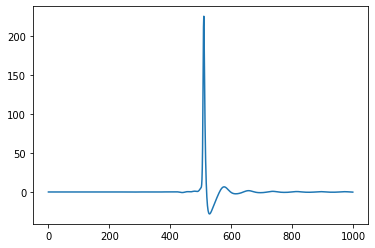

In [39]:
pks = find_peaks(event1_frame_mean, height=0)
st = np.zeros((512, 2978))
st[pks[0],:] = data_stft[pks[0],:]
_, xrec = istft(st, fs=1000, noverlap=16)

# Plot a portion of the spectrogram
plt.plot(xrec[1000:2000])

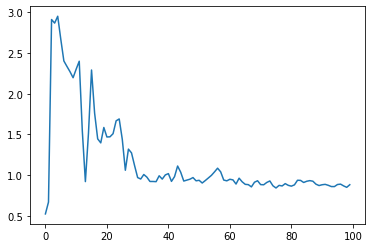

In [40]:
idx1 = np.where(labels2==event2_label)
idx1 = idx1[0]
event1_frame = np.empty((len(idx1),100))
for i,idx in zip(range(len(idx1)),idx1):
    this_frame = data_stft_norm[:,idx]
    event1_frame[i, :] = this_frame.T

event1_frame_mean = np.mean(event1_frame, 0)
plt.plot(event1_frame_mean)

In [28]:
pks1 = find_peaks(event1_frame_mean, height=0)

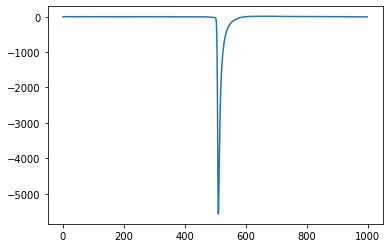

In [47]:
st = np.zeros((512, 2978))
st[pks1[0],:] = data_stft[pks1[0],:]
_, xrec = istft(st, fs=1000, noverlap=16)
plt.plot(xrec[1000:2000])